In [1]:
# Importa bibliotecas
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import plotnine as p9

# Coleta dados Federal Reserve Economic Data https://en.wikipedia.org/wiki/Federal_Reserve_Economic_Data
dados_brutos = pdr.get_data_fred(
  ["USREC",  # Indicador de recessão mensal https://fred.stlouisfed.org/series/USREC
   "GS10",  # Taxa de juros do tesouro americano de longo (10 anos) prazo https://fred.stlouisfed.org/series/T10Y2Y
   "TB3MS", # Taxa de juros do tesouro americano de curto (3 meses) prazo https://fred.stlouisfed.org/series/TB3MS
   "PAYEMS", # Total de empregados na economia, excluindo agrícolas https://fred.stlouisfed.org/series/PAYEMS
   "CPIAUCSL"], # Índice de inflação urbana https://fred.stlouisfed.org/series/CPIAUCSL?cid=9
  start = "1975-01-01"
  )
dados_brutos

,USREC,GS10,TB3MS,PAYEMS,CPIAUCSL
DATE,,,,,
1975-01-01,1,7.50,6.26,77293,52.300
1975-02-01,1,7.39,5.50,76918,52.600
1975-03-01,1,7.73,5.49,76648,52.800
1975-04-01,0,8.23,5.61,76460,53.000
1975-05-01,0,8.06,5.23,76624,53.100
...,...,...,...,...,...
2023-10-01,0,4.80,5.34,156832,307.531
2023-11-01,0,4.50,5.27,157014,308.024
2023-12-01,0,4.02,5.24,157304,308.742


In [2]:
# Realizar os tratamentos
dados_tratados = (
    dados_brutos
    .assign(
      spread_yield = dados_brutos["GS10"] - dados_brutos["TB3MS"],
      USREC = dados_brutos["USREC"].shift(-12).astype("category"),
      GS10_lag3 = dados_brutos["GS10"].shift(3),
      GS10_lag6 = dados_brutos["GS10"].shift(6),
      GS10_lag9 = dados_brutos["GS10"].shift(9),
      GS10_lag12 = dados_brutos["GS10"].shift(12)
      )
    .loc["1980":]
    .reset_index(names = "date")
    )
dados_tratados

,date,USREC,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
0,1980-01-01,0.0,10.80,12.00,90800,78.000,-1.20,10.30,8.95,9.18,9.10
1,1980-02-01,0.0,12.41,12.86,90883,79.000,-0.45,10.65,9.03,9.25,9.10
2,1980-03-01,0.0,12.75,15.20,90994,80.100,-2.45,10.39,9.33,8.91,9.12
3,1980-04-01,0.0,11.47,13.20,90849,80.900,-1.73,10.80,10.30,8.95,9.18
4,1980-05-01,0.0,10.18,8.58,90420,81.700,1.60,12.41,10.65,9.03,9.25
...,...,...,...,...,...,...,...,...,...,...,...
525,2023-10-01,NaN,4.80,5.34,156832,307.531,-0.54,3.90,3.46,3.53,3.98
526,2023-11-01,NaN,4.50,5.27,157014,308.024,-0.77,4.17,3.57,3.75,3.89
527,2023-12-01,NaN,4.02,5.24,157304,308.742,-1.22,4.38,3.75,3.66,3.62
528,2024-01-01,NaN,4.06,5.22,157533,309.685,-1.16,4.80,3.90,3.46,3.53


In [3]:
# Modelo de Regressão Logística
lr_model = LogisticRegression(
  penalty = "l1",
  solver = "liblinear",
  max_iter = 1000
  )

# Modelo Random Forest
rf_model = RandomForestClassifier()

# Modelo k-Nearest Neighbors
knn_model = KNeighborsClassifier()


In [4]:

# Definir as variáveis preditoras e a variável de resposta
X = dados_tratados.dropna().drop(columns = ["USREC", "date"])
y = dados_tratados.dropna()["USREC"]

# Treinar os modelos
lr_model.fit(X, y)
rf_model.fit(X, y)
knn_model.fit(X, y)

# Obtendo as probabilidades previstas
lr_probs = lr_model.predict_proba(X)[:, 1]
rf_probs = rf_model.predict_proba(X)[:, 1]
knn_probs = knn_model.predict_proba(X)[:, 1]

# Criando um DataFrame para armazenar os dados de probabilidade
prob_data = pd.DataFrame({
    "Data": dados_tratados.dropna().date,
    "Indicador NBER": dados_tratados.dropna().USREC,
    "Regressão Logística": lr_probs,
    "Florestas Aleatórias": rf_probs,
    "K Vizinhos Mais Próximos": knn_probs
}).query("Data >= '2005-01-01'")


In [5]:
import plotly.graph_objects as go

# Seus dados
data = prob_data.melt(id_vars="Data", var_name="variavel", value_name="valor")

# Criando o gráfico
fig = go.Figure()

# Adicionando as linhas
for var in data["variavel"].unique():
    subset = data[data["variavel"] == var]
    fig.add_trace(go.Scatter(x=subset["Data"], y=subset["valor"], mode='lines', name=var))

# Personalizando o layout
fig.update_layout(
    title="Probabilidade de Recessão Histórica",
    xaxis=dict(title="", tickformat="%Y", tickmode="linear", dtick="M24"),
    yaxis=dict(title="Probabilidade"),
    legend=dict(x=1.1, y=1),
    annotations=[dict(text="Dados: FRED | Elaboração: Análise Macro", showarrow=False, xref="paper", yref="paper", x=0.5, y=-0.2)]
)

fig.show()


In [6]:
dados_brutos

,USREC,GS10,TB3MS,PAYEMS,CPIAUCSL
DATE,,,,,
1975-01-01,1,7.50,6.26,77293,52.300
1975-02-01,1,7.39,5.50,76918,52.600
1975-03-01,1,7.73,5.49,76648,52.800
1975-04-01,0,8.23,5.61,76460,53.000
1975-05-01,0,8.06,5.23,76624,53.100
...,...,...,...,...,...
2023-10-01,0,4.80,5.34,156832,307.531
2023-11-01,0,4.50,5.27,157014,308.024
2023-12-01,0,4.02,5.24,157304,308.742


In [7]:
# Dados observados omitidos no treinamento
dados_cortados = dados_tratados.set_index("date").query("USREC.isna()")[X.columns.to_list()]
dados_cortados

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2023-03-01,3.66,4.69,155206,301.744,-1.03,3.62,3.52,3.14,2.13
2023-04-01,3.46,4.92,155484,303.032,-1.46,3.53,3.98,2.90,2.75
2023-05-01,3.57,5.14,155787,303.365,-1.57,3.75,3.89,2.90,2.90
2023-06-01,3.75,5.16,156027,304.003,-1.41,3.66,3.62,3.52,3.14
2023-07-01,3.90,5.25,156211,304.628,-1.35,3.46,3.53,3.98,2.90
2023-08-01,4.17,5.30,156421,306.187,-1.13,3.57,3.75,3.89,2.90
2023-09-01,4.38,5.32,156667,307.288,-0.94,3.75,3.66,3.62,3.52
2023-10-01,4.80,5.34,156832,307.531,-0.54,3.90,3.46,3.53,3.98
2023-11-01,4.50,5.27,157014,308.024,-0.77,4.17,3.57,3.75,3.89


In [8]:
# Perído de previsão
periodo_previsao = pd.date_range(
  start = dados_cortados.index.max() + pd.DateOffset(months = 1),
  end = dados_cortados.index.max() + pd.DateOffset(months = 12),
  freq = "MS"
  )
periodo_previsao

DatetimeIndex(['2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01'],
              dtype='datetime64[ns]', freq='MS')

In [9]:
# Função para linearizar do último valor de col até o alvo por h períodos
def cenarizar(df, col, alvo, h = 11):
  resultado = pd.Series(
    [df[col].iloc[-1]] + ([np.nan] * h) + [alvo]).interpolate()[1:]
  return resultado

**Probabilidade de recessão nos EUA:**

- *Cenário pessimista:* taxa curta aumenta linearmente até 15%, taxa longa aumenta linearmente até 10%, total de empregados diminui linearmente até 140000 e inflação aumenta linearmente até 350 no final de 2024.

In [10]:
# Cenário pessimista de previsão futuro
cenario_pessimista = pd.DataFrame(
  data = {
    "date": periodo_previsao,
    "GS10": cenarizar(dados_tratados, "GS10", 10),
    "TB3MS": cenarizar(dados_tratados, "TB3MS", 15),
    "PAYEMS": cenarizar(dados_tratados, "PAYEMS", 140000),
    "CPIAUCSL": cenarizar(dados_tratados, "CPIAUCSL", 350)
  }
).set_index("date")
cenario_pessimista

,GS10,TB3MS,PAYEMS,CPIAUCSL
date,,,,
2024-03-01,4.6925,6.053333,156324.0,314.2995
2024-04-01,5.1750,6.866667,154840.0,317.5450
2024-05-01,5.6575,7.680000,153356.0,320.7905
2024-06-01,6.1400,8.493333,151872.0,324.0360
2024-07-01,6.6225,9.306667,150388.0,327.2815
2024-08-01,7.1050,10.120000,148904.0,330.5270
2024-09-01,7.5875,10.933333,147420.0,333.7725
2024-10-01,8.0700,11.746667,145936.0,337.0180
2024-11-01,8.5525,12.560000,144452.0,340.2635


- *Cenário otimista:* taxa curta diminui linearmente até 2.7%, taxa longa diminui linearmente até 4%, total de empregados aumenta linearmente até 160000 e inflação diminui linearmente até 275 no final de 2024.

In [11]:
# Cenário otimista de previsão futuro
cenario_otimista = pd.DataFrame(
  data = {
    "date": periodo_previsao,
    "GS10": cenarizar(dados_tratados, "GS10", 4),
    "TB3MS": cenarizar(dados_tratados, "TB3MS", 2.7),
    "PAYEMS": cenarizar(dados_tratados, "PAYEMS", 160000),
    "CPIAUCSL": cenarizar(dados_tratados, "CPIAUCSL", 275)
  }
).set_index("date")
cenario_otimista

,GS10,TB3MS,PAYEMS,CPIAUCSL
date,,,,
2024-03-01,4.1925,5.028333,157990.666667,308.0495
2024-04-01,4.1750,4.816667,158173.333333,305.0450
2024-05-01,4.1575,4.605000,158356.000000,302.0405
2024-06-01,4.1400,4.393333,158538.666667,299.0360
2024-07-01,4.1225,4.181667,158721.333333,296.0315
2024-08-01,4.1050,3.970000,158904.000000,293.0270
2024-09-01,4.0875,3.758333,159086.666667,290.0225
2024-10-01,4.0700,3.546667,159269.333333,287.0180
2024-11-01,4.0525,3.335000,159452.000000,284.0135


- *Cenário base:* tudo permanece constante até o final de 2024.

In [12]:
# Cenário base de previsão futuro
cenario_base = (
  pd.concat([dados_tratados.query("date == date.max()")] * 12)
  .assign(date = periodo_previsao)
  .set_index("date")
  .drop("USREC", axis = "columns")
)
cenario_base

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2024-03-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-04-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-05-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-06-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-07-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-08-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-09-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-10-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75
2024-11-01,4.21,5.24,157808,311.054,-1.03,4.5,4.17,3.57,3.75


In [13]:
# Organiza tabelas de cenários
omitido_e_ult12 = pd.concat([
  (
    dados_tratados
    .set_index("date")
    .dropna()
    .tail(12)
    .filter(items = X.columns.to_list(), axis = "columns")
  ),
  dados_cortados
  ])
omitido_e_ult12 

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2022-03-01,2.13,0.44,151370,287.553,1.69,1.47,1.37,1.52,1.61
2022-04-01,2.75,0.76,151642,288.764,1.99,1.76,1.58,1.32,1.64
2022-05-01,2.90,0.98,151928,291.359,1.92,1.93,1.56,1.28,1.62
2022-06-01,3.14,1.49,152348,294.996,1.65,2.13,1.47,1.37,1.52
2022-07-01,2.90,2.23,153038,294.977,0.67,2.75,1.76,1.58,1.32
2022-08-01,2.90,2.63,153281,295.209,0.27,2.90,1.93,1.56,1.28
2022-09-01,3.52,3.13,153536,296.341,0.39,3.14,2.13,1.47,1.37
2022-10-01,3.98,3.72,153897,297.863,0.26,2.90,2.75,1.76,1.58
2022-11-01,3.89,4.15,154155,298.648,-0.26,2.90,2.90,1.93,1.56


In [14]:
tabela_pessimista = (
  pd.concat([omitido_e_ult12, cenario_pessimista])
  .assign(
    spread_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_pessimista

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2023-03-01,3.6600,4.690000,155206.0,301.7440,-1.030000,3.6200,3.5200,3.1400,2.13
2023-04-01,3.4600,4.920000,155484.0,303.0320,-1.460000,3.5300,3.9800,2.9000,2.75
2023-05-01,3.5700,5.140000,155787.0,303.3650,-1.570000,3.7500,3.8900,2.9000,2.90
2023-06-01,3.7500,5.160000,156027.0,304.0030,-1.410000,3.6600,3.6200,3.5200,3.14
2023-07-01,3.9000,5.250000,156211.0,304.6280,-1.350000,3.4600,3.5300,3.9800,2.90
2023-08-01,4.1700,5.300000,156421.0,306.1870,-1.130000,3.5700,3.7500,3.8900,2.90
2023-09-01,4.3800,5.320000,156667.0,307.2880,-0.940000,3.7500,3.6600,3.6200,3.52
2023-10-01,4.8000,5.340000,156832.0,307.5310,-0.540000,3.9000,3.4600,3.5300,3.98
2023-11-01,4.5000,5.270000,157014.0,308.0240,-0.770000,4.1700,3.5700,3.7500,3.89


In [15]:
tabela_otimista = (
  pd.concat([omitido_e_ult12, cenario_otimista])
  .assign(
    spread_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_otimista

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2023-03-01,3.6600,4.690000,155206.000000,301.7440,-1.030000,3.6200,3.5200,3.1400,2.13
2023-04-01,3.4600,4.920000,155484.000000,303.0320,-1.460000,3.5300,3.9800,2.9000,2.75
2023-05-01,3.5700,5.140000,155787.000000,303.3650,-1.570000,3.7500,3.8900,2.9000,2.90
2023-06-01,3.7500,5.160000,156027.000000,304.0030,-1.410000,3.6600,3.6200,3.5200,3.14
2023-07-01,3.9000,5.250000,156211.000000,304.6280,-1.350000,3.4600,3.5300,3.9800,2.90
2023-08-01,4.1700,5.300000,156421.000000,306.1870,-1.130000,3.5700,3.7500,3.8900,2.90
2023-09-01,4.3800,5.320000,156667.000000,307.2880,-0.940000,3.7500,3.6600,3.6200,3.52
2023-10-01,4.8000,5.340000,156832.000000,307.5310,-0.540000,3.9000,3.4600,3.5300,3.98
2023-11-01,4.5000,5.270000,157014.000000,308.0240,-0.770000,4.1700,3.5700,3.7500,3.89


In [16]:
tabela_base = (
  pd.concat([omitido_e_ult12, cenario_base])
  .assign(
    spread_yield = lambda x: x["GS10"] - x["TB3MS"],
    GS10_lag3 = lambda x: x["GS10"].shift(3),
    GS10_lag6 = lambda x: x["GS10"].shift(6),
    GS10_lag9 = lambda x: x["GS10"].shift(9),
    GS10_lag12 = lambda x: x["GS10"].shift(12)
    )
  .dropna()
)
tabela_base

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
date,,,,,,,,,
2023-03-01,3.66,4.69,155206,301.744,-1.03,3.62,3.52,3.14,2.13
2023-04-01,3.46,4.92,155484,303.032,-1.46,3.53,3.98,2.90,2.75
2023-05-01,3.57,5.14,155787,303.365,-1.57,3.75,3.89,2.90,2.90
2023-06-01,3.75,5.16,156027,304.003,-1.41,3.66,3.62,3.52,3.14
2023-07-01,3.90,5.25,156211,304.628,-1.35,3.46,3.53,3.98,2.90
2023-08-01,4.17,5.30,156421,306.187,-1.13,3.57,3.75,3.89,2.90
2023-09-01,4.38,5.32,156667,307.288,-0.94,3.75,3.66,3.62,3.52
2023-10-01,4.80,5.34,156832,307.531,-0.54,3.90,3.46,3.53,3.98
2023-11-01,4.50,5.27,157014,308.024,-0.77,4.17,3.57,3.75,3.89


Para gerar previsão para o futuro escolhemos arbitrariamente o modelo Florestas Aleatórias. O gráfico abaixo exibe as previsões de probabilidade de recessão para a economia dos EUA conforme cada cenário:

In [17]:
# Previsão de probabilidade de recessão
previsao_pessimista = rf_model.predict_proba(tabela_pessimista)[:, 1]
previsao_otimista = rf_model.predict_proba(tabela_otimista)[:, 1]
previsao_base = rf_model.predict_proba(tabela_base)[:, 1]

In [44]:
# Criando um DataFrame para armazenar os dados de previsão
previsoes = (
  pd.DataFrame({
    "Data": tabela_pessimista.index,
    "Indicador NBER": (
      pd.concat([
        dados_brutos.query("index in @tabela_pessimista.index").USREC,
        pd.Series(np.nan, index = tabela_pessimista.tail(12).index)
        ])
      ),
    "Pessimista": previsao_pessimista,
    "Base": previsao_otimista,
    "Otimista": previsao_base
  })
  .assign(
    Pessimista = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Pessimista),
    Base = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Base),
    Otimista = lambda x: np.where(x.Data < periodo_previsao.min(), np.nan, x.Otimista),
    )
)

previsoes

,Data,Indicador NBER,Pessimista,Base,Otimista
2023-03-01,2023-03-01,0.0,NaN,NaN,NaN
2023-04-01,2023-04-01,0.0,NaN,NaN,NaN
2023-05-01,2023-05-01,0.0,NaN,NaN,NaN
2023-06-01,2023-06-01,0.0,NaN,NaN,NaN
2023-07-01,2023-07-01,0.0,NaN,NaN,NaN
2023-08-01,2023-08-01,0.0,NaN,NaN,NaN
2023-09-01,2023-09-01,0.0,NaN,NaN,NaN
2023-10-01,2023-10-01,0.0,NaN,NaN,NaN
2023-11-01,2023-11-01,0.0,NaN,NaN,NaN
2023-12-01,2023-12-01,0.0,NaN,NaN,NaN


<Axes: >

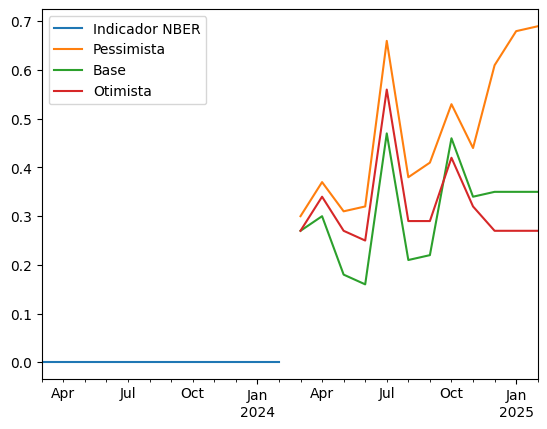

In [45]:
previsoes[['Indicador NBER','Pessimista','Base','Otimista']].plot()

In [19]:
fig = go.Figure()

# Adiciona as linhas ao gráfico
for cenario in  previsoes.cenario.unique():
    fig.add_trace(go.Scatter(x=previsoes[previsoes.cenario==cenario]['Data'], 
                             y=previsoes[previsoes.cenario==cenario]['valor'], 
                             mode='lines', name=cenario))

# Adiciona a linha vertical
fig.add_shape(
    type="line",
    x0=periodo_previsao.min(), y0=0, x1=periodo_previsao.min(), y1=1,
    line=dict(color="black", width=1, dash="dash")
)

# Define os títulos e rótulos
fig.update_layout(
    title=go.layout.Title(
        text="Previsão de Recessão Econômica nos EUA <br><sup>1 = período de recessão, 0 = período de expansão</sup>",
        xref="paper",
        x=0
    ),
    xaxis_title="",
    yaxis_title="Probabilidade",
    xaxis=dict(
        tickmode="linear",
        tick0=0,
        dtick="M3",
        tickformat="%m/%Y"
    )
)
# Exibe o gráfico
fig.show()


In [21]:
X

,GS10,TB3MS,PAYEMS,CPIAUCSL,spread_yield,GS10_lag3,GS10_lag6,GS10_lag9,GS10_lag12
0,10.80,12.00,90800,78.000,-1.20,10.30,8.95,9.18,9.10
1,12.41,12.86,90883,79.000,-0.45,10.65,9.03,9.25,9.10
2,12.75,15.20,90994,80.100,-2.45,10.39,9.33,8.91,9.12
3,11.47,13.20,90849,80.900,-1.73,10.80,10.30,8.95,9.18
4,10.18,8.58,90420,81.700,1.60,12.41,10.65,9.03,9.25
...,...,...,...,...,...,...,...,...,...
513,3.98,3.72,153897,297.863,0.26,2.90,2.75,1.76,1.58
514,3.89,4.15,154155,298.648,-0.26,2.90,2.90,1.93,1.56
515,3.62,4.25,154291,298.812,-0.63,3.52,3.14,2.13,1.47
516,3.53,4.54,154773,300.356,-1.01,3.98,2.90,2.75,1.76


In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
# Pré-processamento: Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Loop para realizar validação cruzada em séries temporais
for train_index, test_index in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Treinar e avaliar o modelo de Regressão Logística
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

    # Treinar e avaliar o modelo Random Forest
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

    # Treinar e avaliar o modelo k-Nearest Neighbors
    knn_model.fit(X_train, y_train)
    knn_pred = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, knn_pred)
    print(f"k-Nearest Neighbors Accuracy: {knn_accuracy:.4f}")


Logistic Regression Accuracy: 0.9070
Random Forest Accuracy: 0.9070
k-Nearest Neighbors Accuracy: 0.9070
Logistic Regression Accuracy: 0.9419
Random Forest Accuracy: 0.9070
k-Nearest Neighbors Accuracy: 0.9302
Logistic Regression Accuracy: 0.7907
Random Forest Accuracy: 0.7907
k-Nearest Neighbors Accuracy: 0.7907
Logistic Regression Accuracy: 1.0000
Random Forest Accuracy: 0.7326
k-Nearest Neighbors Accuracy: 0.9767
Logistic Regression Accuracy: 0.7442
Random Forest Accuracy: 0.9767
k-Nearest Neighbors Accuracy: 0.9767
